In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# -------------------------------
# 1. Data Loading & Preparation
# -------------------------------
# Load the data (adjust the path as needed)
data_path = '../../data/clean/technology/clean_technology_close.csv'
df = pd.read_csv(data_path)

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# -------------------------------
# 2. Calculate Performance Metrics
# -------------------------------
# Normalize prices for easier comparison (base=100)
normalized_df = df.div(df.iloc[0]) * 100

# Calculate total returns (percentage change from first to last day)
start_prices = df.iloc[0]
end_prices = df.iloc[-1]
returns = ((end_prices - start_prices) / start_prices) * 100

# Calculate daily returns, annualized volatility, and Sharpe ratios
daily_returns = df.pct_change().dropna()
volatility = daily_returns.std() * np.sqrt(252)

# Assume an annual risk-free rate of 2%
risk_free_rate = 0.02
daily_rf_rate = risk_free_rate / 252
excess_returns = daily_returns - daily_rf_rate
sharpe_ratios = (excess_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))

# -------------------------------
# 3. Identify Winners, Losers & Benchmarks (by Return)
# -------------------------------
top_n = 5  # number of winners/losers to select
# Winners: stocks with highest total returns
winners_return = returns.nlargest(top_n)
# Losers: stocks with lowest total returns
losers_return = returns.nsmallest(top_n)
# Benchmarks: stocks with total returns closest to the overall average
avg_return = returns.mean()
metric_diff = abs(returns - avg_return)
benchmark_tickers = metric_diff.nsmallest(3).index.tolist()

print("Winners by Return:")
print(winners_return, "\n")
print("Losers by Return:")
print(losers_return, "\n")
print("Benchmark Tickers:")
print(benchmark_tickers, "\n")



Winners by Return:
AMD     731.648870
ACLS    445.837462
LRCX    444.469220
JBL     432.718752
MPWR    415.044336
dtype: float64 

Losers by Return:
CAMP   -98.896278
MIND   -98.500000
LPSN   -96.508220
CMTL   -78.977845
CPSI   -68.127390
dtype: float64 

Benchmark Tickers:
['AZPN', 'KFRC', 'DOV'] 



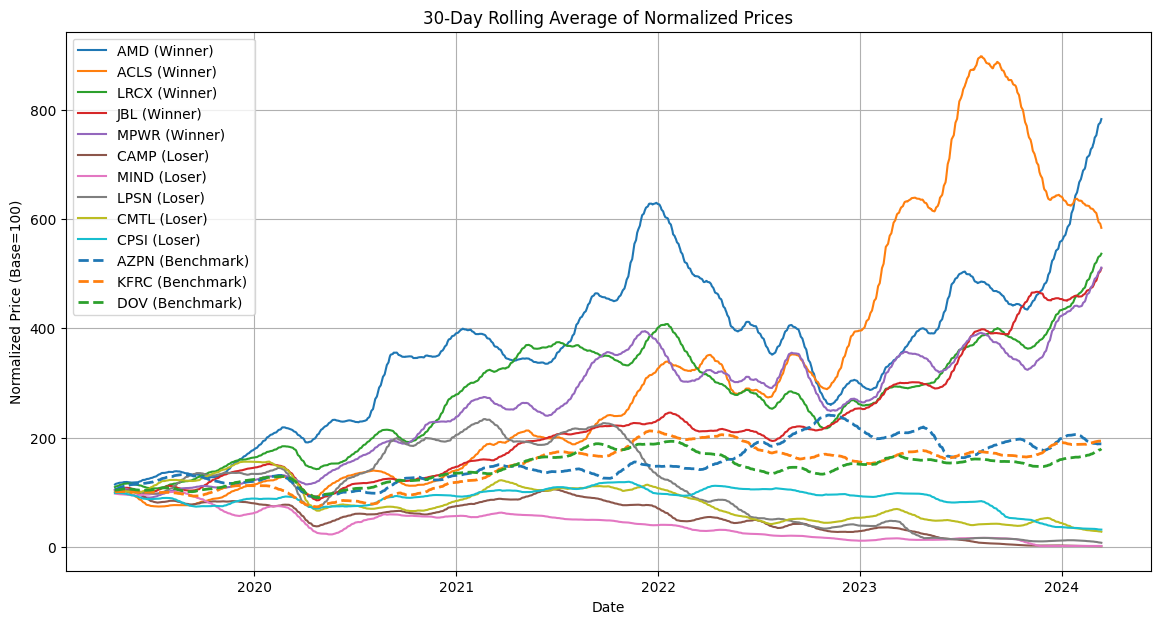

In [57]:
# -------------------------------
# 4. Temporal Performance & Trend Analysis
# -------------------------------
# Calculate a rolling average (e.g., 30-day window) of normalized prices
rolling_window = 30
rolling_mean = normalized_df.rolling(window=rolling_window).mean()

plt.figure(figsize=(14, 7))
# Plot winners
for ticker in winners_return.index:
    plt.plot(rolling_mean.index, rolling_mean[ticker], label=f"{ticker} (Winner)")
# Plot losers
for ticker in losers_return.index:
    plt.plot(rolling_mean.index, rolling_mean[ticker], label=f"{ticker} (Loser)")
# Plot benchmarks with a thicker, dashed line
for ticker in benchmark_tickers:
    plt.plot(rolling_mean.index, rolling_mean[ticker], label=f"{ticker} (Benchmark)",
             linewidth=2, linestyle='--')
plt.title(f'{rolling_window}-Day Rolling Average of Normalized Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price (Base=100)')
plt.legend()
plt.grid(True)
plt.savefig('rolling_average_normalized_prices.png', dpi=300, bbox_inches='tight')  # Save the figure
plt.show()


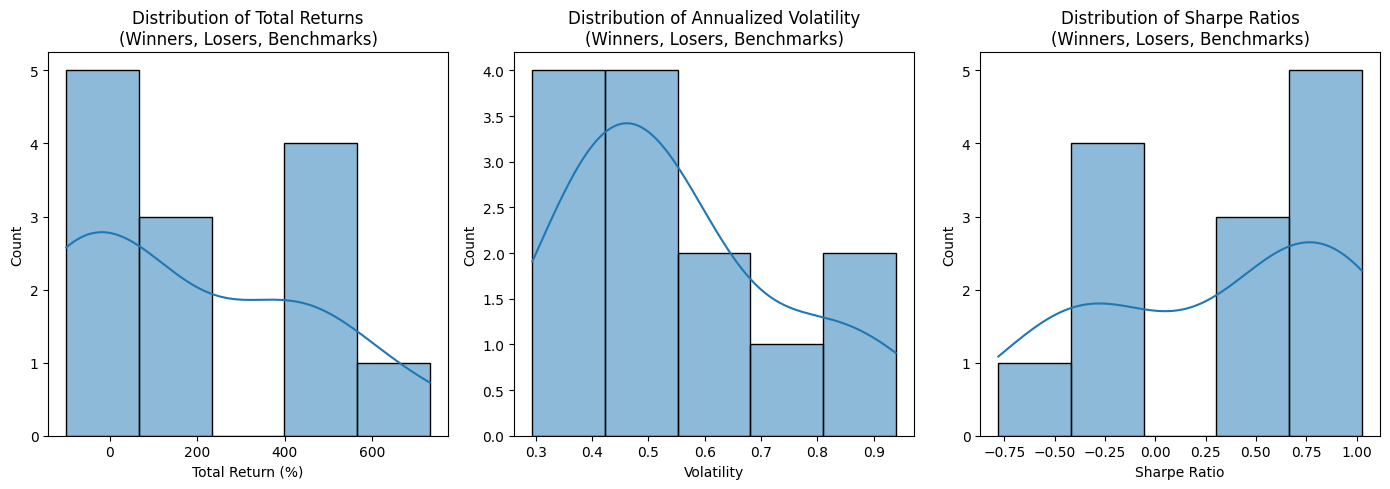

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine tickers from winners, losers, and benchmarks (unique tickers only)
selected_tickers = list(set(winners_return.index.tolist() + losers_return.index.tolist() + benchmark_tickers))

# Filter the series to include only these tickers
selected_returns = returns[selected_tickers]
selected_volatility = volatility[selected_tickers]
selected_sharpe = sharpe_ratios[selected_tickers]

# Plot distributions for the selected groups
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.histplot(selected_returns, kde=True)
plt.title("Distribution of Total Returns\n(Winners, Losers, Benchmarks)")
plt.xlabel("Total Return (%)")

plt.subplot(1, 3, 2)
sns.histplot(selected_volatility, kde=True)
plt.title("Distribution of Annualized Volatility\n(Winners, Losers, Benchmarks)")
plt.xlabel("Volatility")

plt.subplot(1, 3, 3)
sns.histplot(selected_sharpe, kde=True)
plt.title("Distribution of Sharpe Ratios\n(Winners, Losers, Benchmarks)")
plt.xlabel("Sharpe Ratio")

plt.tight_layout()
plt.savefig('distribution_analysis_selected.png', dpi=300, bbox_inches='tight')
plt.show()


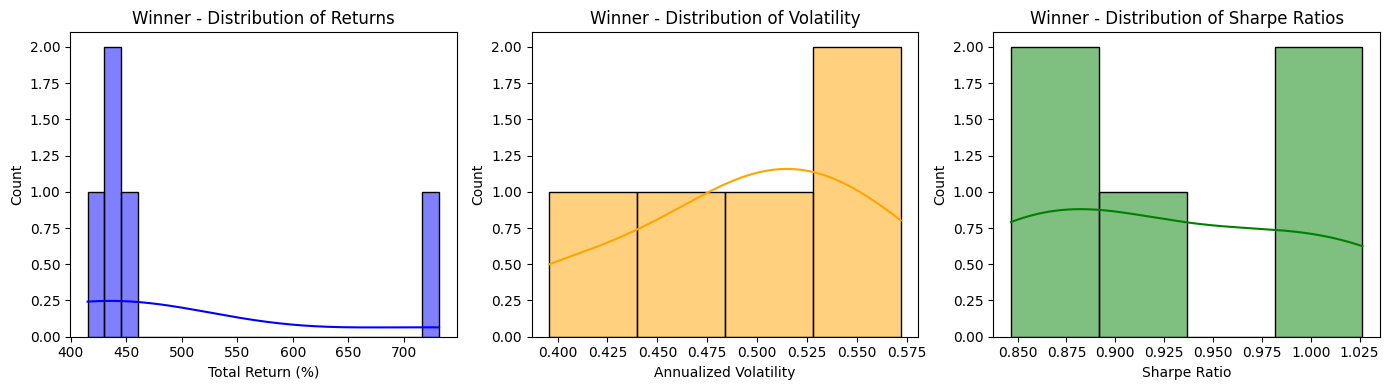

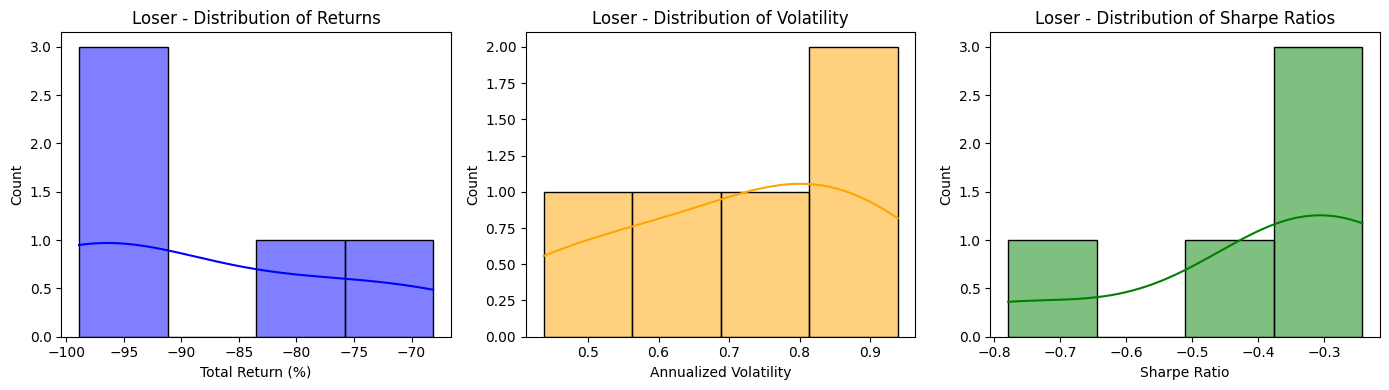

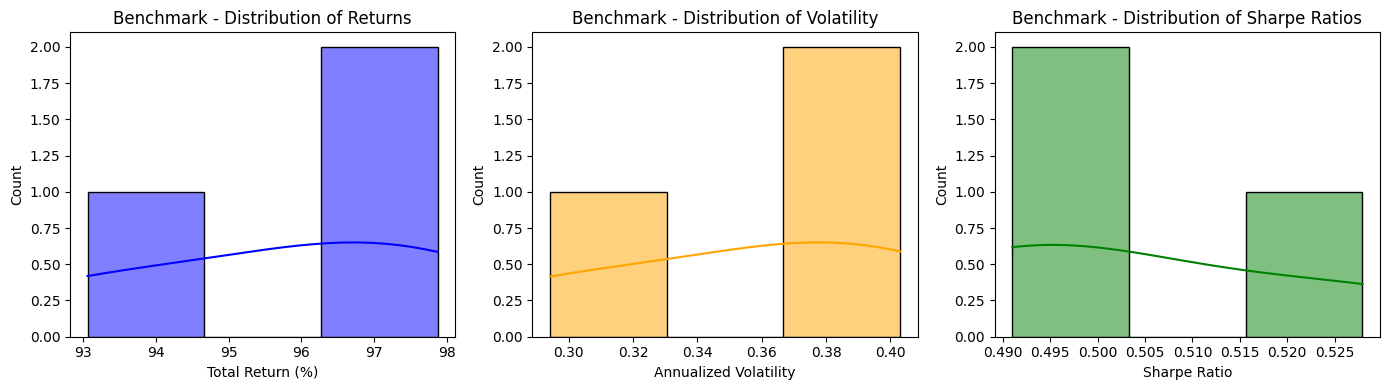

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of groups to plot
groups_to_plot = ["Winner", "Loser", "Benchmark"]

for group in groups_to_plot:
    # Filter rows for the current group
    subset = group_df[group_df["Group"] == group]
    
    # Skip if subset is empty (no tickers in this group)
    if subset.empty:
        continue
    
    # Create a figure with three subplots
    plt.figure(figsize=(14, 4))
    
    # 1. Distribution of Returns
    plt.subplot(1, 3, 1)
    sns.histplot(subset["Return"], kde=True, color='blue')
    plt.title(f"{group} - Distribution of Returns")
    plt.xlabel("Total Return (%)")
    
    # 2. Distribution of Volatility
    plt.subplot(1, 3, 2)
    sns.histplot(subset["Volatility"], kde=True, color='orange')
    plt.title(f"{group} - Distribution of Volatility")
    plt.xlabel("Annualized Volatility")
    
    # 3. Distribution of Sharpe Ratios
    plt.subplot(1, 3, 3)
    sns.histplot(subset["Sharpe"], kde=True, color='green')
    plt.title(f"{group} - Distribution of Sharpe Ratios")
    plt.xlabel("Sharpe Ratio")
    
    plt.tight_layout()
    # Optionally save each figure
    plt.savefig(f'distribution_plots_{group}.png', dpi=300, bbox_inches='tight')
    plt.show()


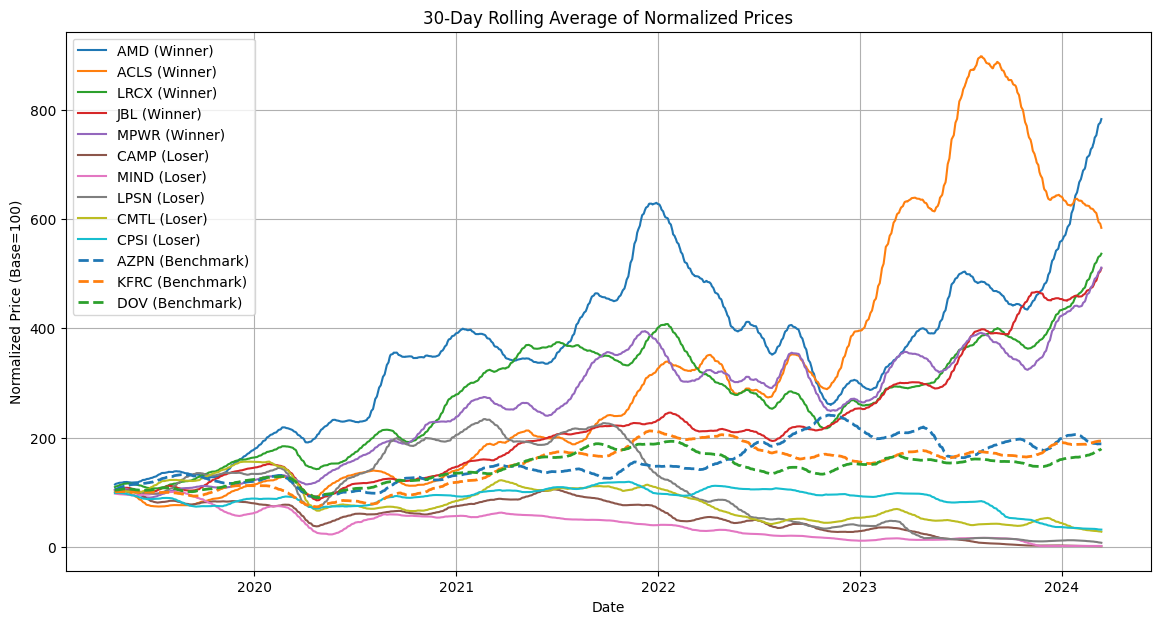

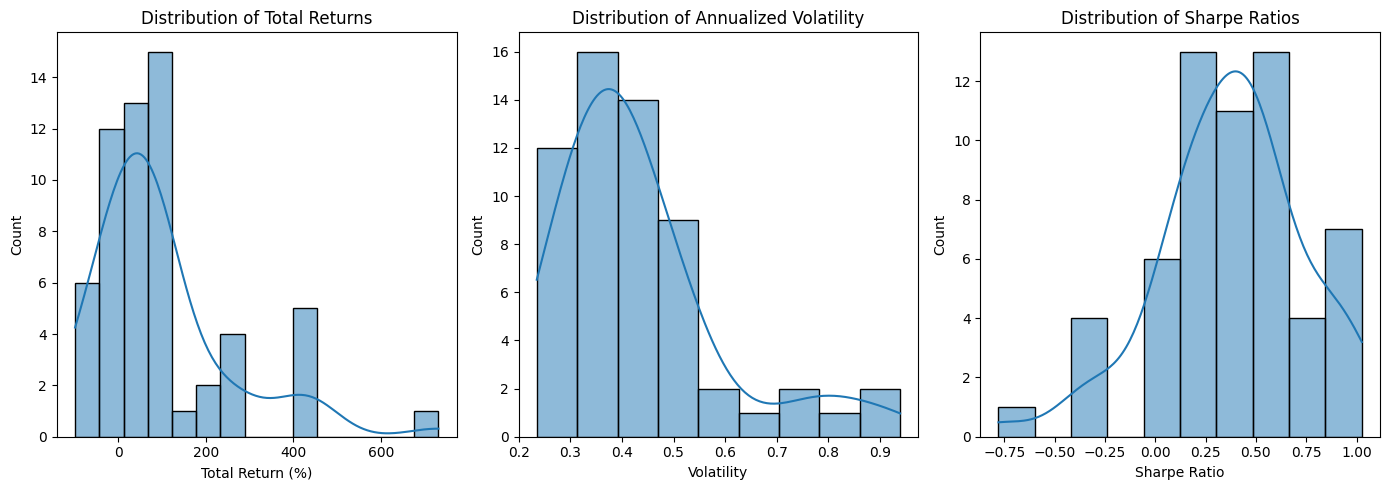

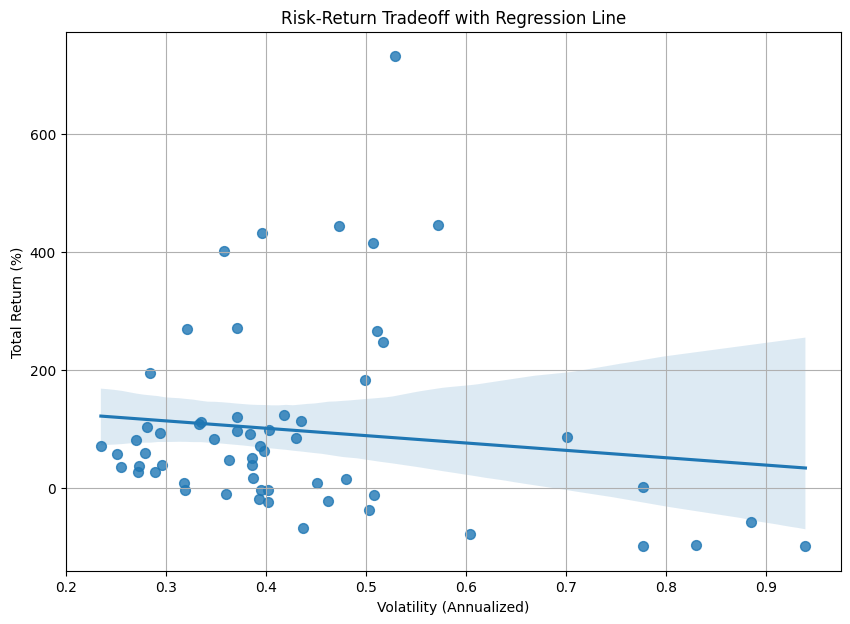

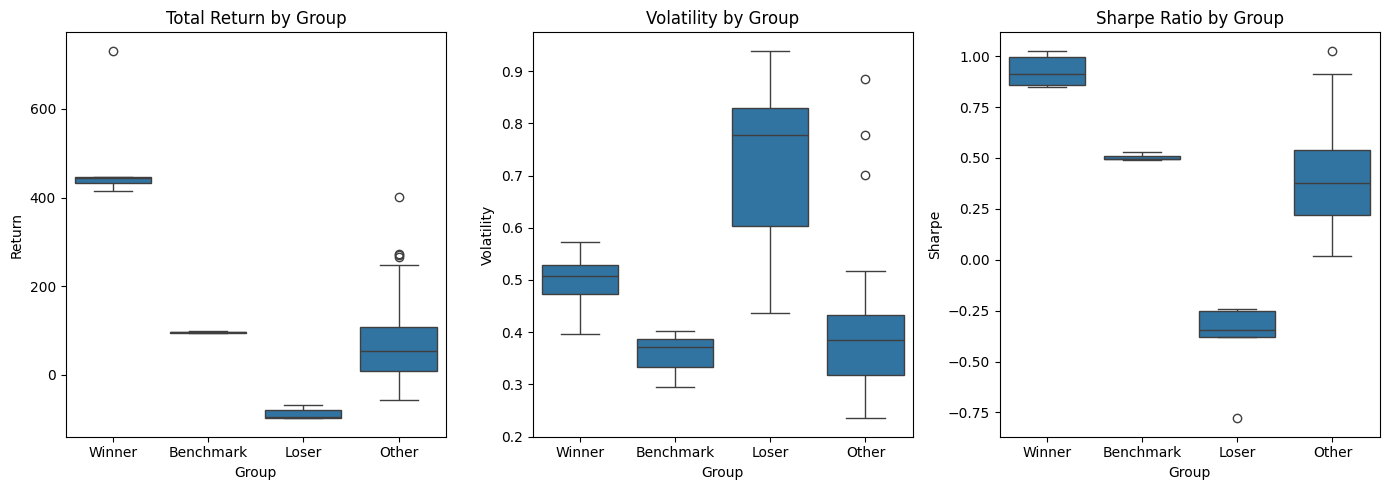

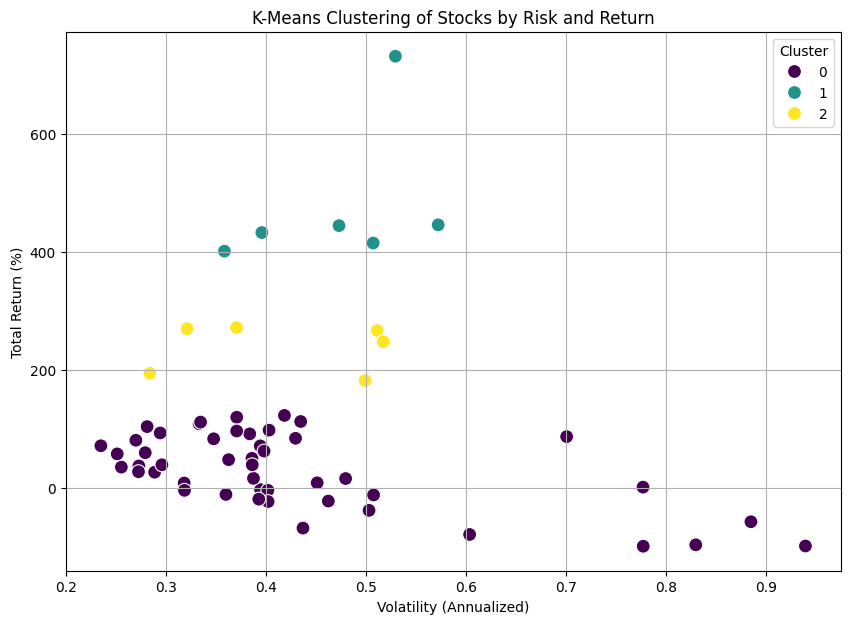

In [ ]:



# -------------------------------
# 6. Risk-Return Relationship
# -------------------------------
plt.figure(figsize=(10, 7))
sns.regplot(x=volatility, y=returns, scatter_kws={'s': 50})
plt.title("Risk-Return Tradeoff with Regression Line")
plt.xlabel("Volatility (Annualized)")
plt.ylabel("Total Return (%)")
plt.grid(True)
plt.show()

# -------------------------------
# 7. Group Comparisons via Boxplots
# -------------------------------
# Create a DataFrame with performance metrics and group labels.
group_labels = {}
for ticker in returns.index:
    if ticker in winners_return.index:
        group_labels[ticker] = "Winner"
    elif ticker in losers_return.index:
        group_labels[ticker] = "Loser"
    elif ticker in benchmark_tickers:
        group_labels[ticker] = "Benchmark"
    else:
        group_labels[ticker] = "Other"

group_df = pd.DataFrame({
    "Return": returns,
    "Volatility": volatility,
    "Sharpe": sharpe_ratios,
    "Group": [group_labels[ticker] for ticker in returns.index]
})

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Group", y="Return", data=group_df, order=["Winner", "Benchmark", "Loser", "Other"])
plt.title("Total Return by Group")

plt.subplot(1, 3, 2)
sns.boxplot(x="Group", y="Volatility", data=group_df, order=["Winner", "Benchmark", "Loser", "Other"])
plt.title("Volatility by Group")

plt.subplot(1, 3, 3)
sns.boxplot(x="Group", y="Sharpe", data=group_df, order=["Winner", "Benchmark", "Loser", "Other"])
plt.title("Sharpe Ratio by Group")

plt.tight_layout()
plt.show()

# -------------------------------
# 8. Segmentation Analysis (Clustering)
# -------------------------------
# Create a DataFrame of the performance metrics for clustering
features = pd.DataFrame({
    "Return": returns,
    "Volatility": volatility,
    "Sharpe": sharpe_ratios
})

# Run k-means clustering with 3 clusters (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
features['Cluster'] = kmeans.fit_predict(features)

plt.figure(figsize=(10, 7))
sns.scatterplot(x="Volatility", y="Return", hue="Cluster", data=features, palette="viridis", s=100)
plt.title("K-Means Clustering of Stocks by Risk and Return")
plt.xlabel("Volatility (Annualized)")
plt.ylabel("Total Return (%)")
plt.grid(True)
plt.show()



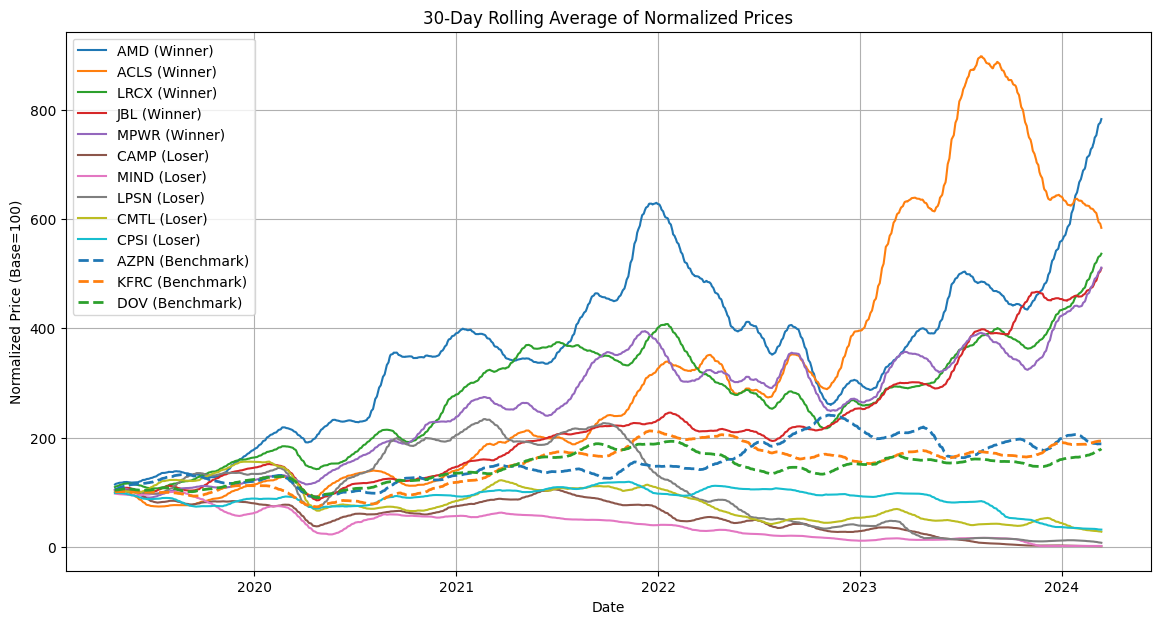

In [45]:
# -------------------------------
# 4. Temporal Performance & Trend Analysis
# -------------------------------
# Calculate a rolling average (e.g., 30-day window) of normalized prices
rolling_window = 30
rolling_mean = normalized_df.rolling(window=rolling_window).mean()

plt.figure(figsize=(14, 7))
# Plot winners
for ticker in winners_return.index:
    plt.plot(rolling_mean.index, rolling_mean[ticker], label=f"{ticker} (Winner)")
# Plot losers
for ticker in losers_return.index:
    plt.plot(rolling_mean.index, rolling_mean[ticker], label=f"{ticker} (Loser)")
# Plot benchmarks with a thicker, dashed line
for ticker in benchmark_tickers:
    plt.plot(rolling_mean.index, rolling_mean[ticker], label=f"{ticker} (Benchmark)",
             linewidth=2, linestyle='--')
plt.title(f'{rolling_window}-Day Rolling Average of Normalized Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price (Base=100)')
plt.legend()
plt.grid(True)
plt.savefig('rolling_average_normalized_prices.png')  # Save the figure
plt.show()


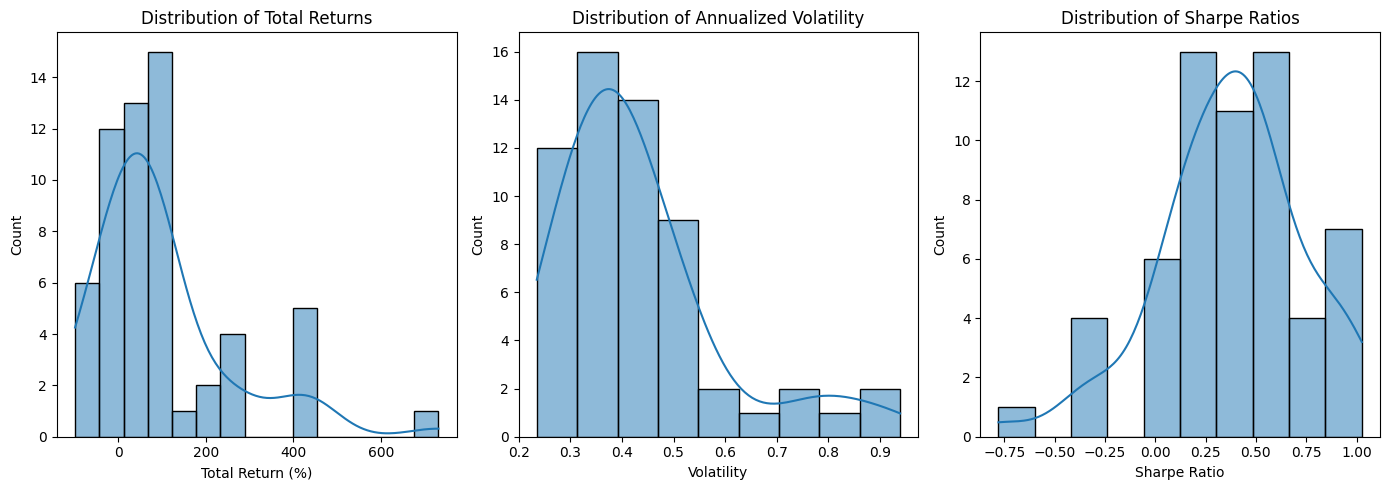

In [46]:

# -------------------------------
# 5. Distribution Analysis
# -------------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.histplot(returns, kde=True)
plt.title("Distribution of Total Returns")
plt.xlabel("Total Return (%)")

plt.subplot(1, 3, 2)
sns.histplot(volatility, kde=True)
plt.title("Distribution of Annualized Volatility")
plt.xlabel("Volatility")

plt.subplot(1, 3, 3)
sns.histplot(sharpe_ratios, kde=True)
plt.title("Distribution of Sharpe Ratios")
plt.xlabel("Sharpe Ratio")

plt.tight_layout()
plt.savefig('distribution_analysis.png')  # Save the figure
plt.show()


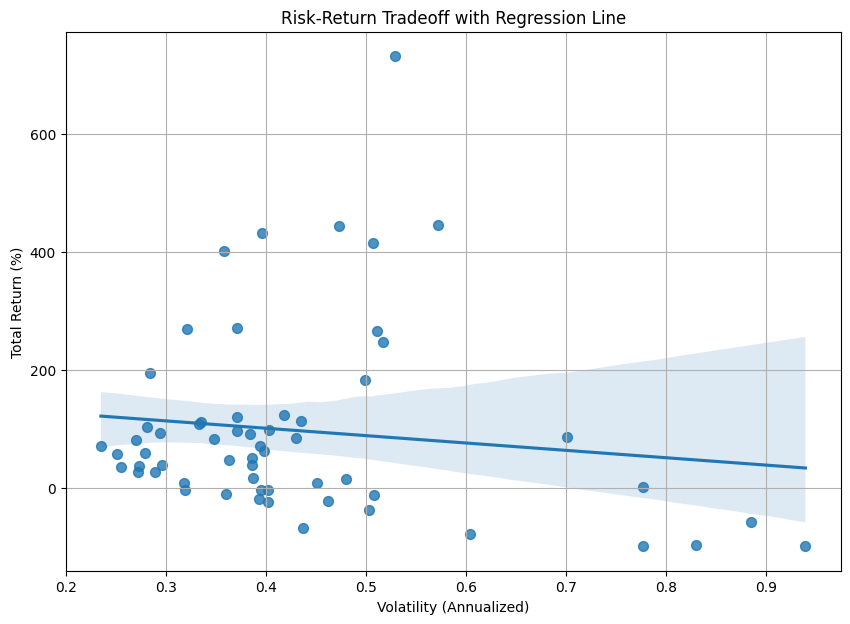

In [47]:

# -------------------------------
# 6. Risk-Return Relationship
# -------------------------------
plt.figure(figsize=(10, 7))
sns.regplot(x=volatility, y=returns, scatter_kws={'s': 50})
plt.title("Risk-Return Tradeoff with Regression Line")
plt.xlabel("Volatility (Annualized)")
plt.ylabel("Total Return (%)")
plt.grid(True)
plt.savefig('risk_return_tradeoff.png')  # Save the figure
plt.show()

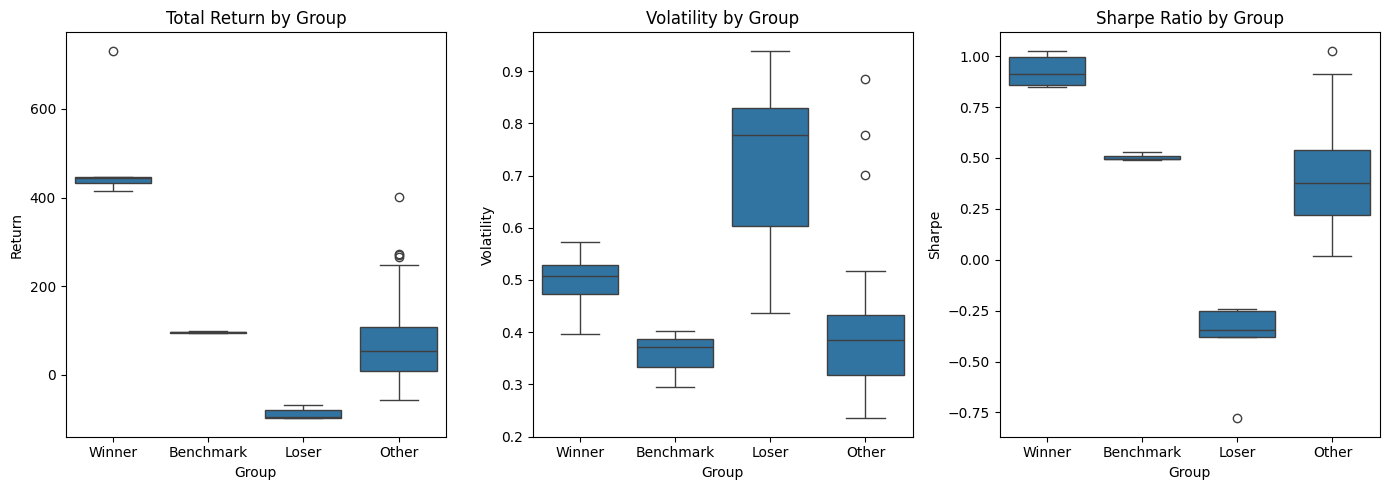

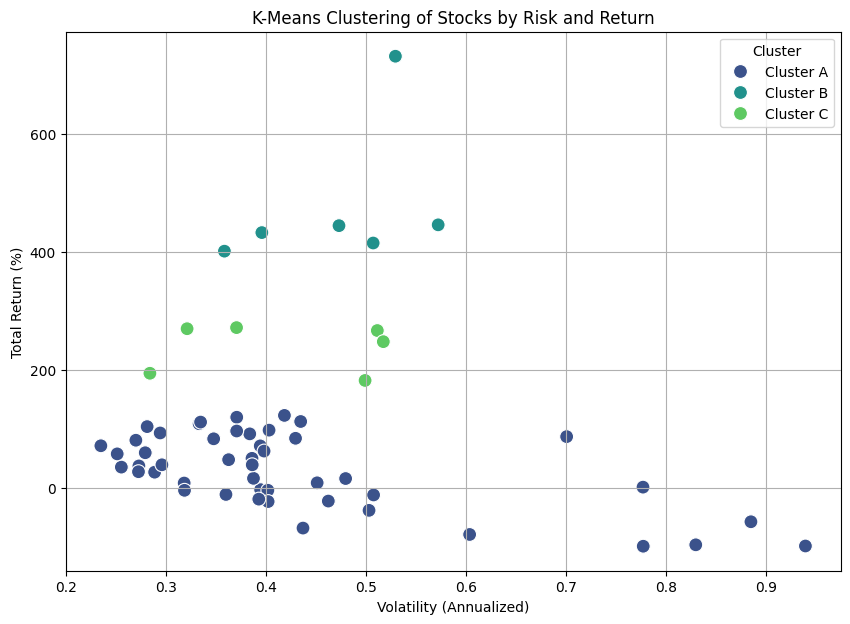


=== Cluster Centers ===
[[3.04663912e+01 4.27146877e-01 2.50585866e-01]
 [4.78491137e+02 4.72607508e-01 9.43754341e-01]
 [2.38723770e+02 4.17168955e-01 7.73684945e-01]]

=== Cluster Assignments ===
          Return  Volatility    Sharpe    Cluster
ACIW   -3.047672    0.394594  0.131603  Cluster A
ACLS  445.837462    0.572081  0.846596  Cluster B
ADBE  119.732953    0.370713  0.557771  Cluster A
ADI    83.169872    0.347636  0.465260  Cluster A
ADP    59.552477    0.279230  0.403960  Cluster A


In [48]:


# -------------------------------
# 7. Group Comparisons via Boxplots
# -------------------------------
# Create a dictionary assigning each ticker to a group
group_labels = {}
for ticker in returns.index:
    if ticker in winners_return.index:
        group_labels[ticker] = "Winner"
    elif ticker in losers_return.index:
        group_labels[ticker] = "Loser"
    elif ticker in benchmark_tickers:
        group_labels[ticker] = "Benchmark"
    else:
        group_labels[ticker] = "Other"

# Create a DataFrame with performance metrics and group labels
group_df = pd.DataFrame({
    "Return": returns,
    "Volatility": volatility,
    "Sharpe": sharpe_ratios,
    "Group": [group_labels[ticker] for ticker in returns.index]
})

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Group", y="Return", data=group_df,
            order=["Winner", "Benchmark", "Loser", "Other"])
plt.title("Total Return by Group")

plt.subplot(1, 3, 2)
sns.boxplot(x="Group", y="Volatility", data=group_df,
            order=["Winner", "Benchmark", "Loser", "Other"])
plt.title("Volatility by Group")

plt.subplot(1, 3, 3)
sns.boxplot(x="Group", y="Sharpe", data=group_df,
            order=["Winner", "Benchmark", "Loser", "Other"])
plt.title("Sharpe Ratio by Group")

plt.tight_layout()
plt.savefig('group_comparisons_boxplots.png')
plt.show()

# -------------------------------
# 8. Segmentation Analysis (Clustering)
# -------------------------------
# Create a DataFrame of the performance metrics for clustering
features = pd.DataFrame({
    "Return": returns,
    "Volatility": volatility,
    "Sharpe": sharpe_ratios
})

# Handle missing values if present
features = features.dropna()  # or features.fillna(features.mean())

# Run k-means clustering with 3 clusters (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
features['Cluster_ID'] = kmeans.fit_predict(features)

# Map numeric cluster IDs to descriptive labels
cluster_labels = {
    0: "Cluster A",
    1: "Cluster B",
    2: "Cluster C"
}
features['Cluster'] = features['Cluster_ID'].map(cluster_labels)

# Plot the clusters on a risk-return scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x="Volatility", y="Return", hue="Cluster", data=features,
                palette="viridis", s=100)
plt.title("K-Means Clustering of Stocks by Risk and Return")
plt.xlabel("Volatility (Annualized)")
plt.ylabel("Total Return (%)")
plt.grid(True)
plt.savefig('kmeans_clustering_risk_return.png')
plt.show()

# Optional: Inspect cluster centers
print("\n=== Cluster Centers ===")
print(kmeans.cluster_centers_)
print("\n=== Cluster Assignments ===")
print(features[['Return', 'Volatility', 'Sharpe', 'Cluster']].head())


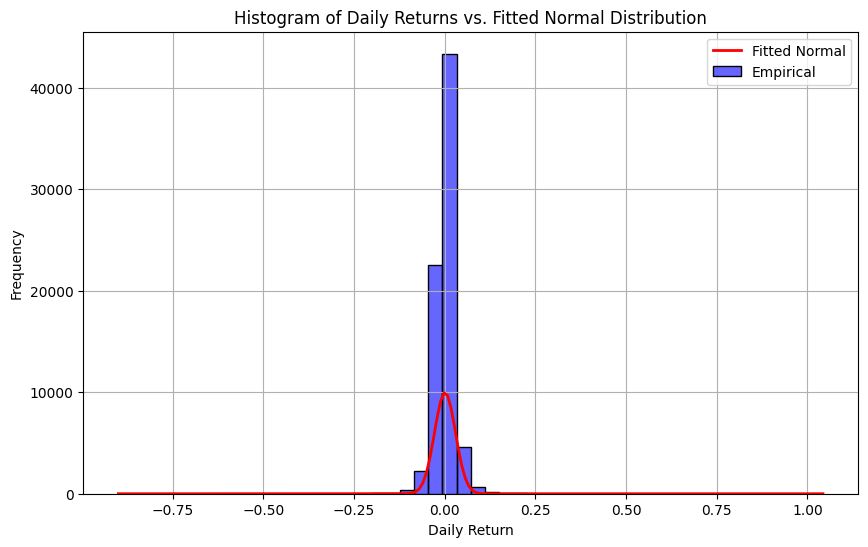

<Figure size 800x600 with 0 Axes>

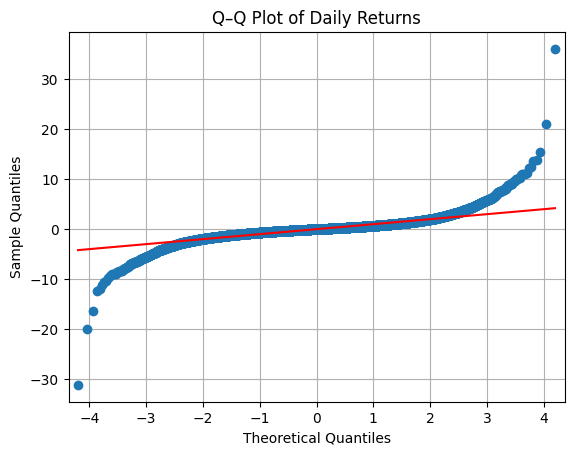

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

# -----------------------------------------------------
# Example: Visualizing "fat tails" of daily returns
# -----------------------------------------------------

# 1. Prepare your daily returns data
# daily_returns = pd.read_csv('your_daily_returns.csv', index_col='Date', parse_dates=True)
# Suppose each column in 'daily_returns' is a different stock's daily return.

# Flatten the DataFrame into a single Series of returns
all_returns = daily_returns.stack()  # merges all columns into one Series
all_returns.dropna(inplace=True)     # drop any missing values

# -----------------------------------------------------
# 2. HISTOGRAM WITH FITTED NORMAL CURVE
# -----------------------------------------------------
plt.figure(figsize=(10, 6))

# Plot histogram of actual returns
sns.histplot(all_returns, kde=False, color='blue', bins=50, alpha=0.6, label='Empirical')

# Fit a normal distribution and overlay
mu, std = stats.norm.fit(all_returns)
xmin, xmax = all_returns.min(), all_returns.max()
x = np.linspace(xmin, xmax, 200)
p = stats.norm.pdf(x, mu, std)  # theoretical normal pdf
p_scaled = p * len(all_returns) * (xmax - xmin) / 200  # scale pdf to histogram area

plt.plot(x, p_scaled, 'r', linewidth=2, label='Fitted Normal')
plt.title('Histogram of Daily Returns vs. Fitted Normal Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Save the histogram figure
plt.savefig('histogram_vs_normal.png', dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------------------------------
# 3. Q–Q PLOT
# -----------------------------------------------------
plt.figure(figsize=(8, 6))
sm.qqplot(all_returns, line='s', fit=True)
plt.title('Q–Q Plot of Daily Returns')
plt.grid(True)

# Save the Q-Q plot figure
plt.savefig('qq_plot.png', dpi=300, bbox_inches='tight')
plt.show()


# -----------------------------------------------------
# Interpretation:
# -----------------------------------------------------
# 1) If the histogram’s tails (left or right) extend beyond
#    the red normal curve, it suggests “fat tails” (leptokurtosis).
# 2) In the Q–Q plot, if points deviate significantly from
#    the straight line in the upper or lower tails, that also
#    indicates heavier (or lighter) tails than the normal distribution.


full code

Winners by Return:
AMD     731.648870
ACLS    445.837462
LRCX    444.469220
JBL     432.718752
MPWR    415.044336
dtype: float64 

Losers by Return:
CAMP   -98.896278
MIND   -98.500000
LPSN   -96.508220
CMTL   -78.977845
CPSI   -68.127390
dtype: float64 

Benchmark Tickers:
['AZPN', 'KFRC', 'DOV'] 



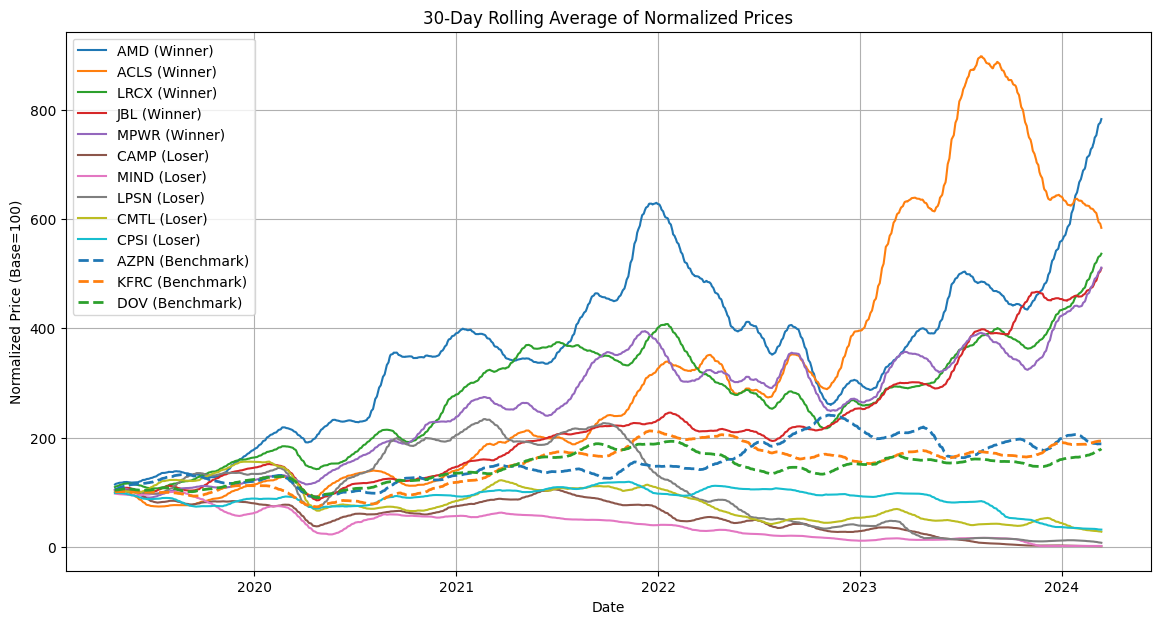

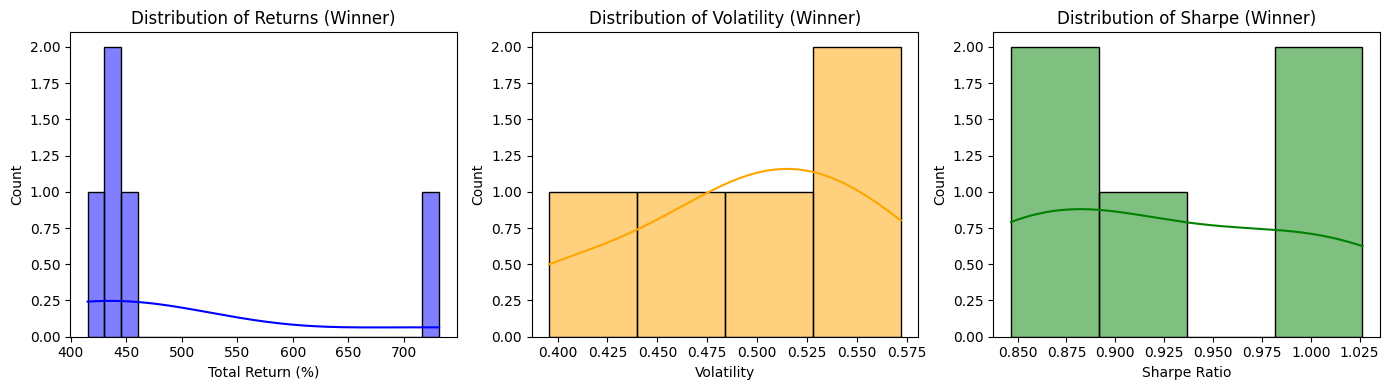

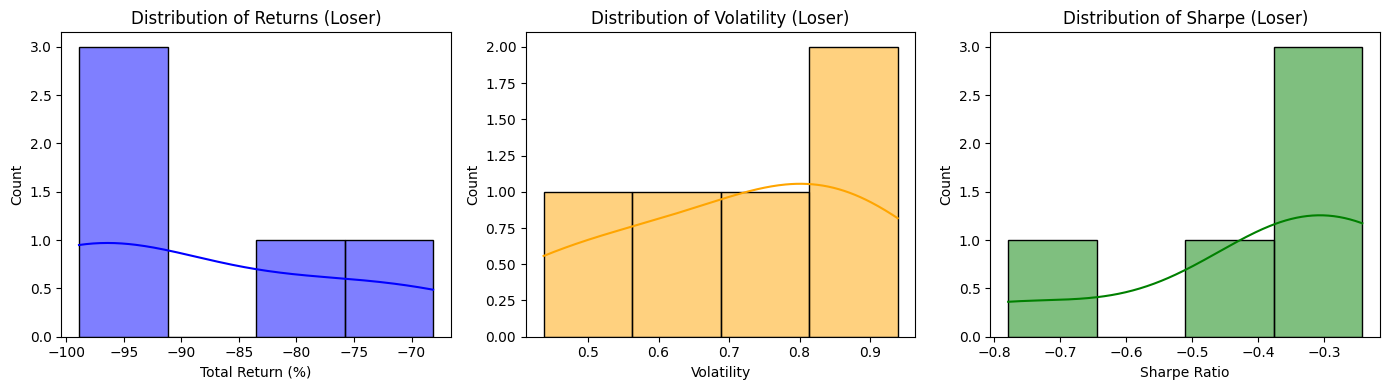

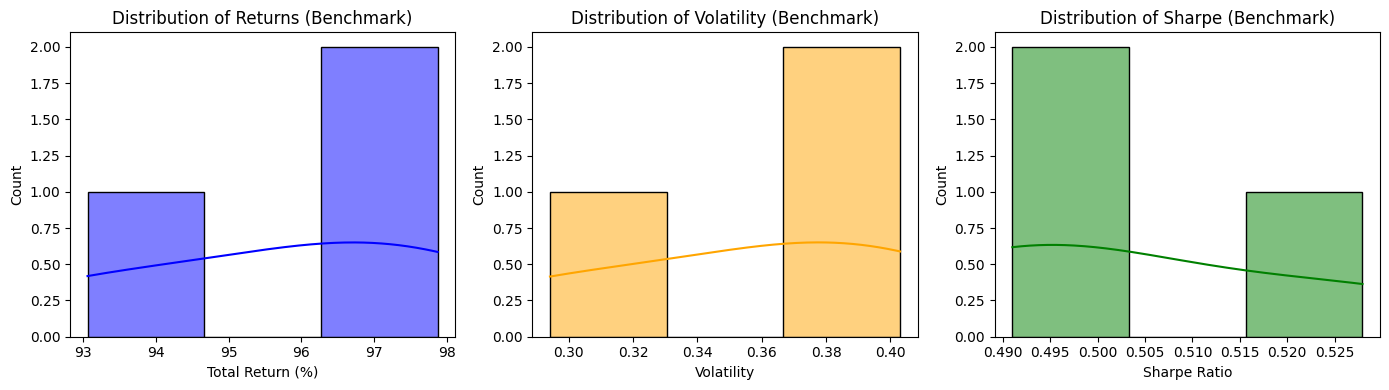

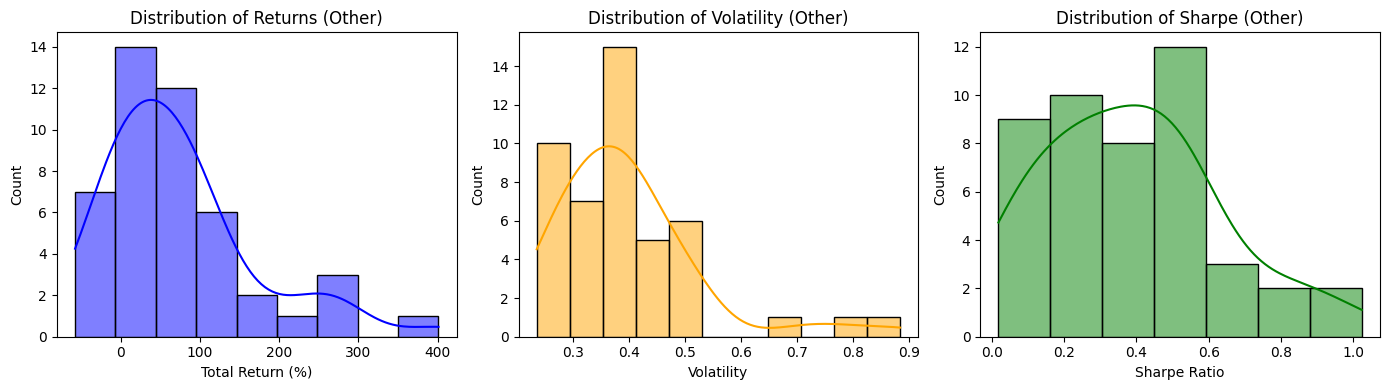

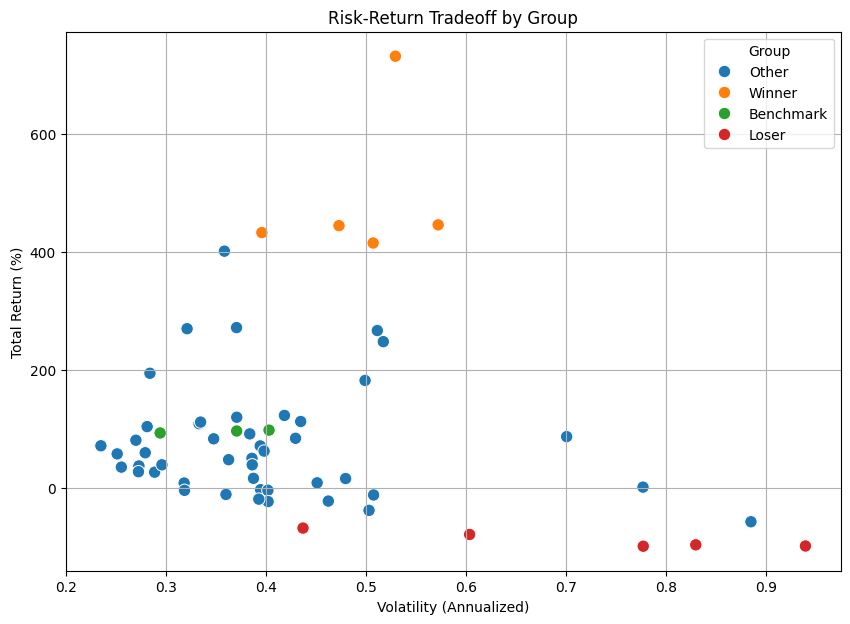

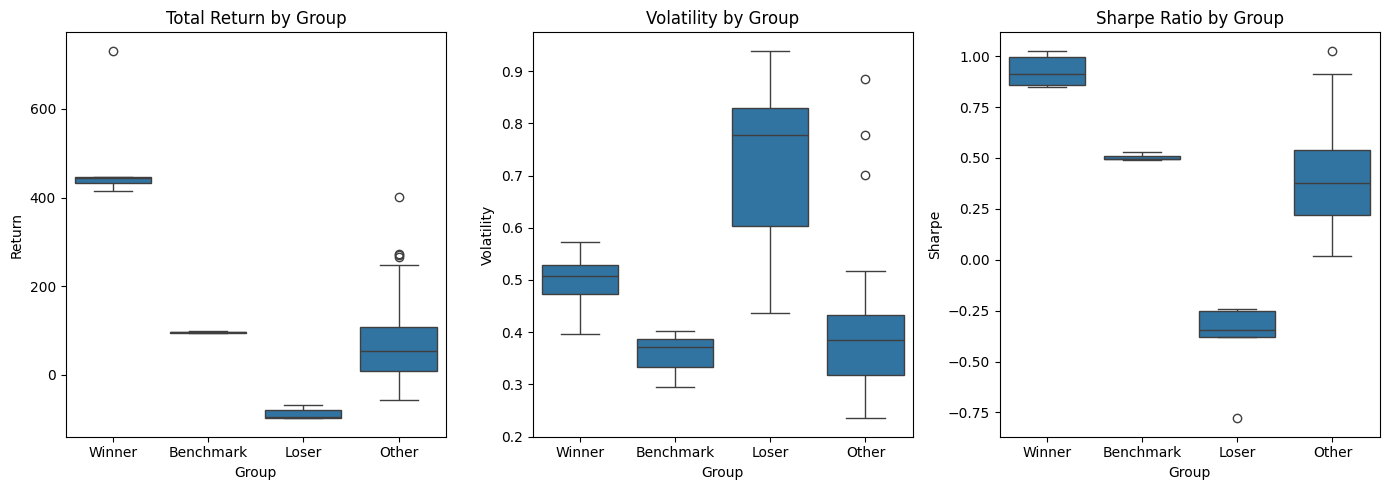

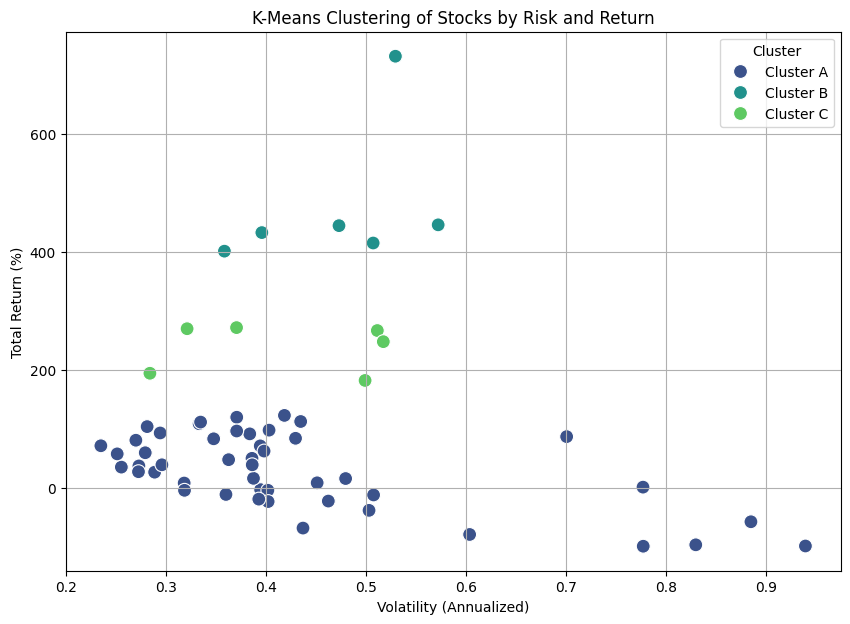


=== K-Means Cluster Centers ===
[[3.04663912e+01 4.27146877e-01 2.50585866e-01]
 [4.78491137e+02 4.72607508e-01 9.43754341e-01]
 [2.38723770e+02 4.17168955e-01 7.73684945e-01]]

=== First 10 with cluster & group ===
          Return  Volatility    Sharpe  Cluster_ID    Cluster      Group
ACIW   -3.047672    0.394594  0.131603           0  Cluster A      Other
ACLS  445.837462    0.572081  0.846596           1  Cluster B     Winner
ADBE  119.732953    0.370713  0.557771           0  Cluster A      Other
ADI    83.169872    0.347636  0.465260           0  Cluster A      Other
ADP    59.552477    0.279230  0.403960           0  Cluster A      Other
ADSK   71.163118    0.394203  0.420108           0  Cluster A      Other
AGYS  266.699299    0.511256  0.726513           2  Cluster C      Other
AMD   731.648870    0.529335  1.026467           1  Cluster B     Winner
ASGN   62.394301    0.398034  0.394205           0  Cluster A      Other
AZPN   97.869189    0.403016  0.491000           0  C

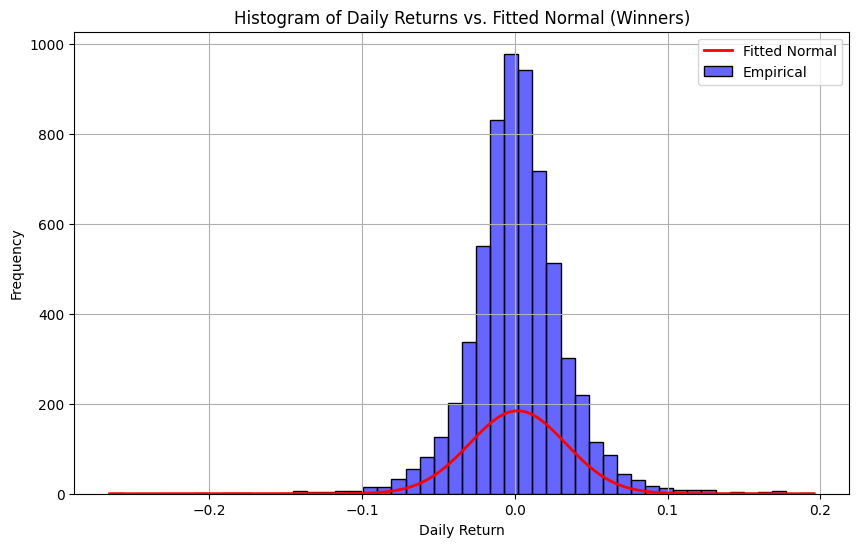

<Figure size 800x600 with 0 Axes>

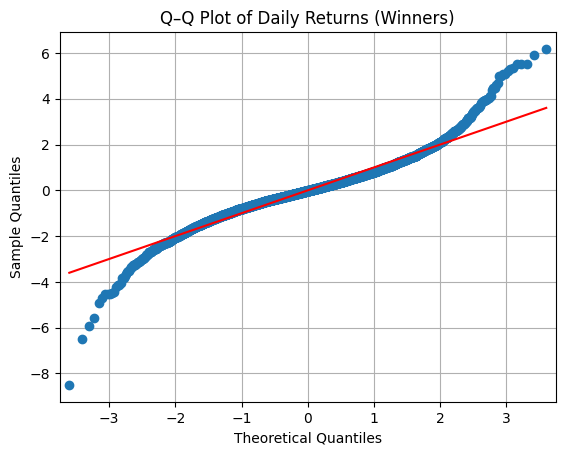

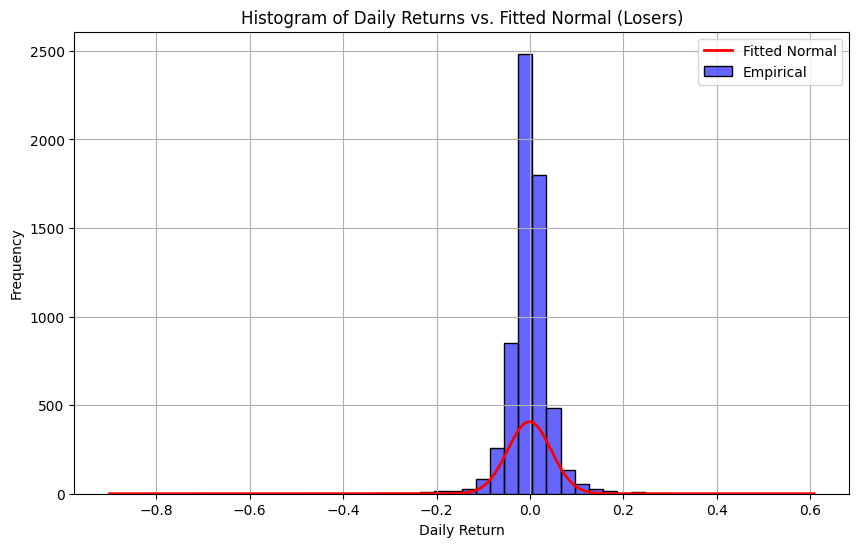

<Figure size 800x600 with 0 Axes>

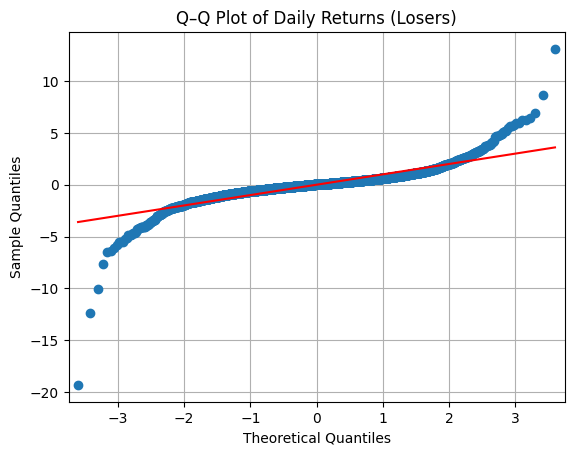

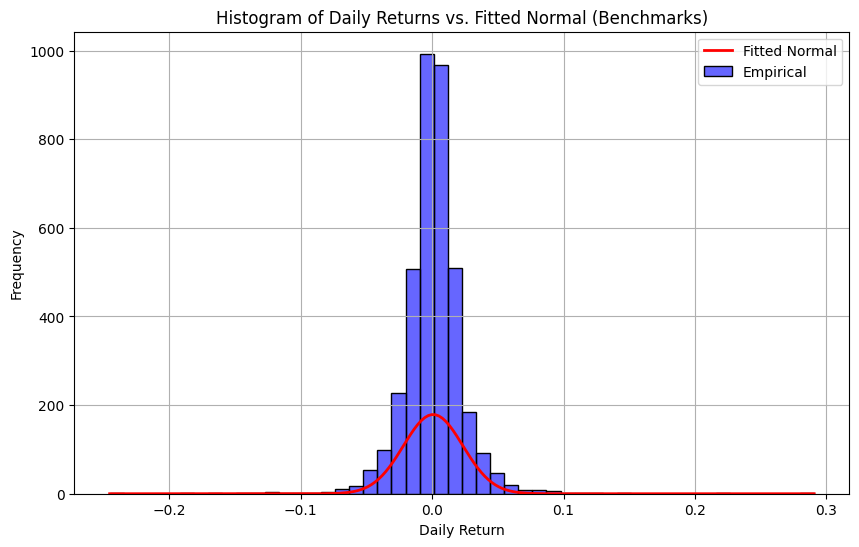

<Figure size 800x600 with 0 Axes>

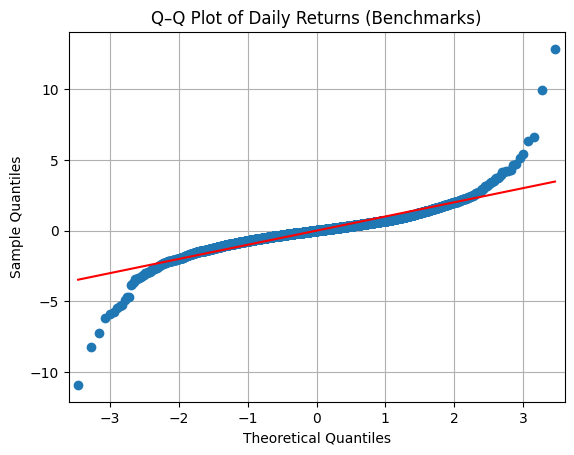

All plots saved. Analysis complete!


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import statsmodels.api as sm
import scipy.stats as stats

# ----------------------------------------
# 1. Data Loading & Preparation
# ----------------------------------------
data_path = '../../data/clean/technology/clean_technology_close.csv'
df = pd.read_csv(data_path)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# ----------------------------------------
# 2. Calculate Performance Metrics
# ----------------------------------------
normalized_df = df.div(df.iloc[0]) * 100

start_prices = df.iloc[0]
end_prices = df.iloc[-1]
returns = ((end_prices - start_prices) / start_prices) * 100

daily_returns = df.pct_change().dropna()
volatility = daily_returns.std() * np.sqrt(252)

# Assume 2% annual risk-free rate
risk_free_rate = 0.02
daily_rf_rate = risk_free_rate / 252
excess_returns = daily_returns - daily_rf_rate
sharpe_ratios = (excess_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))

# ----------------------------------------
# 3. Identify Winners, Losers & Benchmarks (by Return)
# ----------------------------------------
top_n = 5
winners_return = returns.nlargest(top_n)  # top 5
losers_return = returns.nsmallest(top_n)  # bottom 5

avg_return = returns.mean()
metric_diff = abs(returns - avg_return)
benchmark_tickers = metric_diff.nsmallest(3).index.tolist()

print("Winners by Return:")
print(winners_return, "\n")
print("Losers by Return:")
print(losers_return, "\n")
print("Benchmark Tickers:")
print(benchmark_tickers, "\n")

# Create a dictionary assigning each ticker to a group
group_labels = {}
for ticker in returns.index:
    if ticker in winners_return.index:
        group_labels[ticker] = "Winner"
    elif ticker in losers_return.index:
        group_labels[ticker] = "Loser"
    elif ticker in benchmark_tickers:
        group_labels[ticker] = "Benchmark"
    else:
        group_labels[ticker] = "Other"

# Create a DataFrame with performance metrics and group labels
group_df = pd.DataFrame({
    "Return": returns,
    "Volatility": volatility,
    "Sharpe": sharpe_ratios,
    "Group": [group_labels[ticker] for ticker in returns.index]
})

# ----------------------------------------
# 4. Temporal Performance & Trend Analysis
# ----------------------------------------
rolling_window = 30
rolling_mean = normalized_df.rolling(window=rolling_window).mean()

plt.figure(figsize=(14, 7))
# Plot winners
for ticker in winners_return.index:
    plt.plot(rolling_mean.index, rolling_mean[ticker], label=f"{ticker} (Winner)")
# Plot losers
for ticker in losers_return.index:
    plt.plot(rolling_mean.index, rolling_mean[ticker], label=f"{ticker} (Loser)")
# Plot benchmarks
for ticker in benchmark_tickers:
    plt.plot(rolling_mean.index, rolling_mean[ticker],
             label=f"{ticker} (Benchmark)", linewidth=2, linestyle='--')

plt.title(f'{rolling_window}-Day Rolling Average of Normalized Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price (Base=100)')
plt.legend()
plt.grid(True)
plt.savefig('rolling_average_normalized_prices.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------------------
# 5. Distribution Analysis (for each group)
# ----------------------------------------
# We'll loop through each group: Winner, Loser, Benchmark, Other
unique_groups = ["Winner", "Loser", "Benchmark", "Other"]
for g in unique_groups:
    subset = group_df[group_df["Group"] == g]
    if subset.empty:
        continue  # skip if no stocks in this group

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    sns.histplot(subset["Return"], kde=True, color='blue')
    plt.title(f"Distribution of Returns ({g})")
    plt.xlabel("Total Return (%)")

    plt.subplot(1, 3, 2)
    sns.histplot(subset["Volatility"], kde=True, color='orange')
    plt.title(f"Distribution of Volatility ({g})")
    plt.xlabel("Volatility")

    plt.subplot(1, 3, 3)
    sns.histplot(subset["Sharpe"], kde=True, color='green')
    plt.title(f"Distribution of Sharpe ({g})")
    plt.xlabel("Sharpe Ratio")

    plt.tight_layout()
    plt.savefig(f'distribution_analysis_{g}.png', dpi=300, bbox_inches='tight')
    plt.show()

# ----------------------------------------
# 6. Risk-Return Relationship (color-coded by group)
# ----------------------------------------
plt.figure(figsize=(10, 7))
sns.scatterplot(data=group_df, x="Volatility", y="Return", hue="Group", s=80)
plt.title("Risk-Return Tradeoff by Group")
plt.xlabel("Volatility (Annualized)")
plt.ylabel("Total Return (%)")
plt.grid(True)
plt.savefig('risk_return_by_group.png', dpi=300, bbox_inches='tight')
plt.show()

# If you want separate regression lines, you can loop or use 'sns.lmplot' with 'col' or 'hue'.

# ----------------------------------------
# 7. Group Comparisons via Boxplots
# ----------------------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Group", y="Return", data=group_df,
            order=["Winner", "Benchmark", "Loser", "Other"])
plt.title("Total Return by Group")

plt.subplot(1, 3, 2)
sns.boxplot(x="Group", y="Volatility", data=group_df,
            order=["Winner", "Benchmark", "Loser", "Other"])
plt.title("Volatility by Group")

plt.subplot(1, 3, 3)
sns.boxplot(x="Group", y="Sharpe", data=group_df,
            order=["Winner", "Benchmark", "Loser", "Other"])
plt.title("Sharpe Ratio by Group")

plt.tight_layout()
plt.savefig('group_comparisons_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------------------
# 8. Segmentation Analysis (K-Means Clustering)
# ----------------------------------------
features = pd.DataFrame({
    "Return": returns,
    "Volatility": volatility,
    "Sharpe": sharpe_ratios
}).dropna()

kmeans = KMeans(n_clusters=3, random_state=42)
features["Cluster_ID"] = kmeans.fit_predict(features)

# Map numeric cluster IDs to descriptive labels
cluster_labels = {
    0: "Cluster A",
    1: "Cluster B",
    2: "Cluster C"
}
features["Cluster"] = features["Cluster_ID"].map(cluster_labels)

plt.figure(figsize=(10, 7))
sns.scatterplot(x="Volatility", y="Return", hue="Cluster", data=features, palette="viridis", s=100)
plt.title("K-Means Clustering of Stocks by Risk and Return")
plt.xlabel("Volatility (Annualized)")
plt.ylabel("Total Return (%)")
plt.grid(True)
plt.savefig('kmeans_clustering_risk_return.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== K-Means Cluster Centers ===")
print(kmeans.cluster_centers_)

# Add group labels to 'features' if desired, to see which group each stock is in
features["Group"] = features.index.map(lambda x: group_labels.get(x, "Unknown"))
print("\n=== First 10 with cluster & group ===")
print(features.head(10))

# ----------------------------------------
# Fat Tails Analysis (Histogram & Q-Q Plot for each group)
# ----------------------------------------
# We'll subset daily_returns for each group, then flatten into a Series to see distribution of daily returns.

def plot_fat_tails_for_group(group_name, tickers, daily_ret_df):
    """Plots histogram vs. normal and Q–Q plot for the given group of tickers."""
    # Filter the daily returns DataFrame to only these tickers
    subset_df = daily_ret_df[tickers].dropna(how='all', axis=1)
    if subset_df.empty:
        print(f"No daily returns for group: {group_name}")
        return
    
    # Flatten into one long Series
    stacked_returns = subset_df.stack().dropna()

    # 1. HISTOGRAM WITH FITTED NORMAL
    plt.figure(figsize=(10, 6))
    sns.histplot(stacked_returns, kde=False, color='blue', bins=50, alpha=0.6, label='Empirical')
    mu, std = stats.norm.fit(stacked_returns)
    xmin, xmax = stacked_returns.min(), stacked_returns.max()
    x = np.linspace(xmin, xmax, 200)
    p = stats.norm.pdf(x, mu, std)
    p_scaled = p * len(stacked_returns) * (xmax - xmin) / 200
    plt.plot(x, p_scaled, 'r', linewidth=2, label='Fitted Normal')
    plt.title(f'Histogram of Daily Returns vs. Fitted Normal ({group_name})')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'fat_tails_histogram_{group_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Q–Q PLOT
    plt.figure(figsize=(8, 6))
    sm.qqplot(stacked_returns, line='s', fit=True)
    plt.title(f'Q–Q Plot of Daily Returns ({group_name})')
    plt.grid(True)
    plt.savefig(f'fat_tails_qqplot_{group_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Now run the fat tails plot for each group
groups_to_check = {
    "Winners": winners_return.index,
    "Losers": losers_return.index,
    "Benchmarks": benchmark_tickers
    # If you want "Others", you can define them similarly.
}

for g_name, g_tickers in groups_to_check.items():
    plot_fat_tails_for_group(g_name, g_tickers, daily_returns)

print("All plots saved. Analysis complete!")


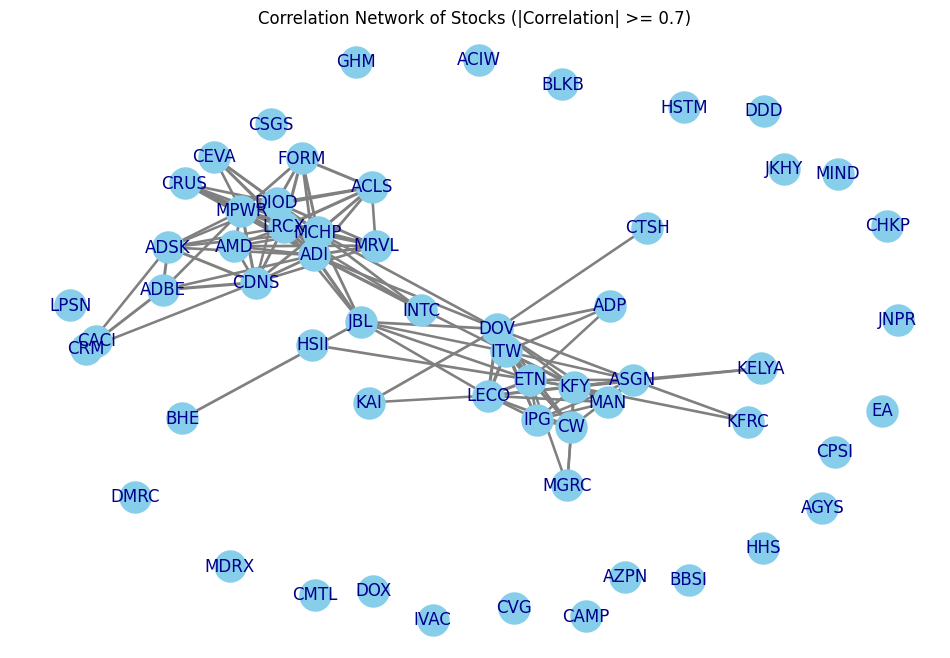

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# ------------------------------------------------
# 1. Data Loading & Preparation
# ------------------------------------------------
data_path = '../../data/clean/technology/clean_technology_close.csv'
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Compute daily returns and drop NaN values
daily_returns = df.pct_change().dropna()

# ------------------------------------------------
# 2. Build Correlation Matrix and Threshold Edges
# ------------------------------------------------
# Compute correlation matrix for stocks
corr_matrix = daily_returns.corr()

# Set a threshold for correlation strength
threshold = 0.6  # you can adjust this value

# Create an undirected graph
G = nx.Graph()

# Add nodes for each stock
for stock in corr_matrix.columns:
    G.add_node(stock)

# Add edges between stocks if absolute correlation is above the threshold
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        stock_i = corr_matrix.columns[i]
        stock_j = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) >= threshold:
            # Add edge with the correlation value as weight
            G.add_edge(stock_i, stock_j, weight=corr_value)

# ------------------------------------------------
# 3. Visualize the Network
# ------------------------------------------------
plt.figure(figsize=(12, 8))

# Use a spring layout for positioning nodes
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_color='darkblue')

# Draw edges with widths proportional to correlation magnitude
edges = G.edges(data=True)
edge_widths = [abs(data['weight']) * 3 for (_, _, data) in edges]
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray')

plt.title("Correlation Network of Stocks (|Correlation| >= 0.7)")
plt.axis('off')
plt.savefig('correlation_network.png', dpi=300, bbox_inches='tight')
plt.show()
